In [1]:
#Here info:
#App ID: gB5Th31Aa7kCMDRB2yYH
#App Code: _V3OMdtHzj0vDll0eT6JsA

from sklearn.ensemble import RandomForestClassifier
from sklearn import (metrics, model_selection, linear_model, preprocessing, ensemble, neighbors, tree,svm,datasets)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pydotplus
import seaborn as sns
import numpy as np
import pandas as pd
import pprint as pp
import re
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier,plot_tree,to_graphviz
from IPython.display import Image 
from scipy import interp
from itertools import cycle

%matplotlib inline

# markdown syntax:
# https://daringfireball.net/projects/markdown/syntax#header

In [2]:
import txdot_parse as txpars
import helpers

# Introduction

# Data Preparation

## Preprocessing

In [3]:
# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

In [4]:
# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)

## Impute Missing Values

In [5]:
data.speed_limit.replace(0,np.nan,inplace=True)
data.speed_limit.replace(-1,np.nan,inplace=True)
# impute speed limits
print("########################################")
verbose=0
if(verbose):
    print(data.speed_limit.value_counts())
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("pre : total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
data = txpars.impute_mph(data, verbose=0)
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("post: total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
    print(data.speed_limit.value_counts())
    print(data.info())
print("########################################")

########################################
pre : total missing speed limit data:
 575 (0.2576164874551971 of 1)
post: total missing speed limit data:
 458 (0.20519713261648745 of 1)
########################################


# Exploration

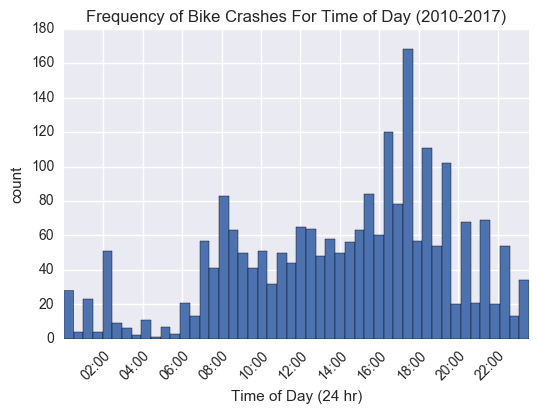

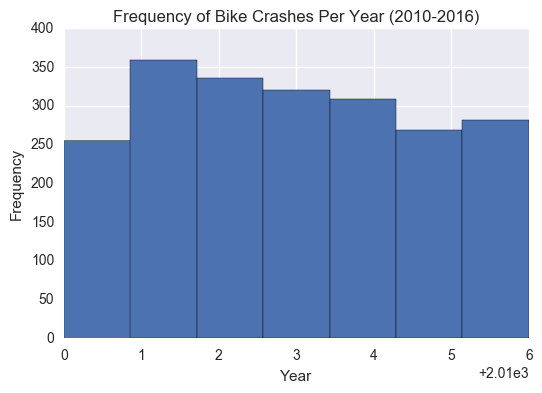

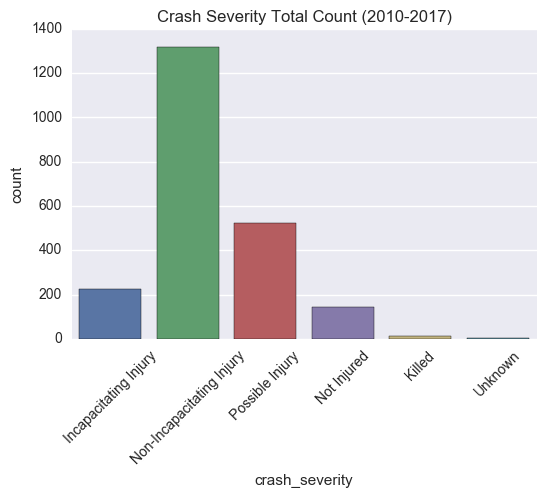

In [6]:
# Let's see the realationship between crashes and time of day
# First, let's just look at the total crashes vs time of day (no crash severity)

data = pd.read_csv("my_map_grid.csv",header=10)
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')

# add 
ax_time = helpers.get_ax_time(
        interval = '24h',
        title = 'Frequency of Bike Crashes For Time of Day (2010-2017)',
        xlabel = 'Time of Day (24 hr)',
        ylabel = 'count',
        )

data.crash_time.hist(bins=48,ax=ax_time)
plt.show()

# Let's see if there is a trend of total bike crashes by year
# We'll ignore 2017 data since it is incomplete
# histogram
if(1):
    data.crash_year[data.crash_year != 2017].plot.hist(bins=7)
    plt.xlabel('Year')
    plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
    plt.show()
# bar chart
else:
    plt.bar(data.crash_year[data.crash_year != 2017].value_counts().index, data.crash_year[data.crash_year != 2017].value_counts().values)
    plt.xlabel('Year')
    plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
    plt.show()

# Spread of Crash Severity data from 2010-2017
# Using seaborn for ease of use with categorical data
sns.countplot(x="crash_severity", data=data);
plt.xticks(rotation=45)
plt.title('Crash Severity Total Count (2010-2017)')
plt.show()


In [7]:
print("Total Crashes involving Severe Injuries and fatalities from 2010-2017")
import IPython
url = 'https://yoinkbird.github.io/crashes.html'
iframe = '<iframe src=' + url + ' width=700 height=525></iframe>'
IPython.display.HTML(iframe)

Total Crashes involving Severe Injuries and fatalities from 2010-2017


# Analysis

## DecisionTree

Tree train accuracy:  0.617391304348
Tree test accuracy:  0.575305291723


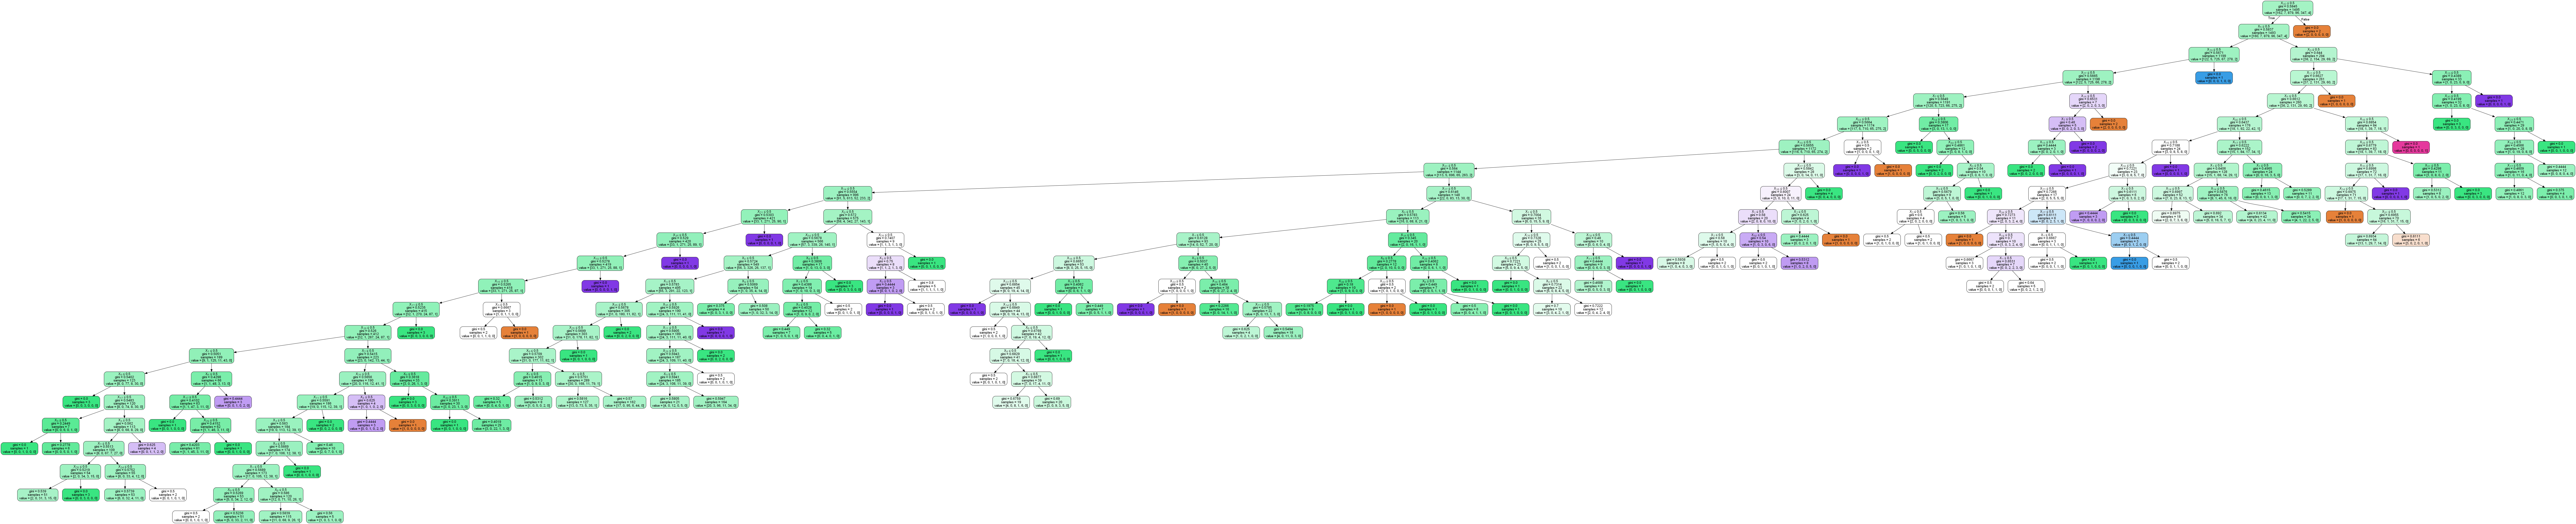

In [8]:
# Use DecisionTreeClassifier with a limited number of features and visualize
# the the resulting tree

# https://research.vahula.com/scikit-learns-decision-tree-classifier-698ddbb05b
# http://scikit-learn.org/stable/modules/tree.html





# Let's select a small number of important features
# smalldf = data[['crash_severity',
#                 'crash_time', 
#                 'day_of_week', 
#                 'intersection_related', 
#                 'light_condition', 
#                 'manner_of_collision',
#                 'speed_limit',
#                 'surface_condition', 
#                 'weather_condition']]

# smalldf.head()

# dummies_needed_list = [
#  'day_of_week',
#  'intersection_related',
#  'light_condition',
#  'manner_of_collision',
#  'surface_condition',
#  'weather_condition']

smalldf = data[['crash_severity', 
                'intersection_related', 
                'light_condition', 
                'manner_of_collision',
                'surface_condition', 
                'weather_condition']]

smalldf.head()

dummies_needed_list = [
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'surface_condition',
 'weather_condition']

# encode data for dummies_needed_list
for feat in dummies_needed_list:
    smalldf = pd.concat([smalldf,pd.get_dummies(smalldf[feat],prefix=feat)],axis=1)
    smalldf = smalldf.drop([feat],axis=1)
    
smalldf.head()
X = smalldf.drop(['crash_severity'], axis=1)
y = smalldf['crash_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)

train_accuracy = tree_classifier.score(X_train, y_train)
test_accuracy = tree_classifier.score(X_test, y_test)
print('Tree train accuracy: ', train_accuracy)
print('Tree test accuracy: ', test_accuracy)

# graphviz needs to be installed
# on mac: brew install graphviz
# http://stackoverflow.com/questions/18438997/why-is-pydot-unable-to-find-graphvizs-executables-in-windows-8

# The feature_names and class_names oprtional parameters should be set so that the tree
# can have the actual names of features and classes
# http://scikit-learn.org/stable/modules/tree.html#classification
dot_data = tree.export_graphviz(tree_classifier, out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#print(tree_classifier.feature_importances_)


Confusion matrix, without normalization


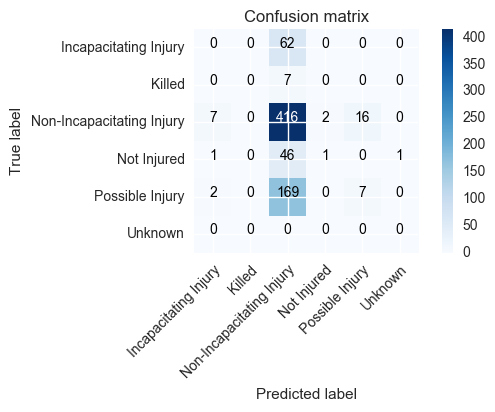

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,tree_classifier.predict(X_test))
helpers.plot_confusion_matrix(cm,classes=tree_classifier.classes_)

## XGB - Extreme Gradient Boosting

In [10]:
# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)


dummies_needed_list = [
 'day_of_week',
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'road_base_type',
 'surface_condition',
 'weather_condition'
        ]

# encode data for dummies_needed_list
for feat in dummies_needed_list:
    data = pd.concat([data,pd.get_dummies(data[feat],prefix=feat)],axis=1)
    data = data.drop([feat],axis=1)

#remove data that will not be usefull
drop_columns = ['crash_id',
                'average_daily_traffic_amount',
                'average_daily_traffic_year',
                'street_name',
                'intersecting_street_name',
                'medical_advisory_flag',
                'object_struck',
               'crash_death_count',
               'crash_incapacitating_injury_count',
                'crash_non-incapacitating_injury_count',
               'crash_not_injured_count',
               'crash_possible_injury_count']
crash_id = data.crash_id
data = data.drop(drop_columns,axis=1)

#fix time column
data['100th_time']=data.crash_time/100
data['minutes'] = (data['100th_time']-data['100th_time'].apply(np.floor))*100
data['100th_time'] = (data['100th_time'].apply(np.floor))*60
data.crash_time = data.minutes+data['100th_time']
data.drop(['minutes'],axis=1,inplace=True)
data.drop(['100th_time'],axis=1,inplace=True)

#fill missing values
data = data.fillna(data.mean())

#split data into train/test,x/y
np.random.seed(0)

# The minimum number of groups for any class cannot be less than n_splits=5
# crash_severity == 'Unknown' has only 4 samples
train, test = train_test_split(data[data['crash_severity'] != 'Unknown'])
x_train = train.drop(['crash_severity'],axis=1)
y_train = train.crash_severity
x_test = test.drop(['crash_severity'],axis=1)
y_test = test.crash_severity


In [11]:
#cross validation function
def accuracy_cv(model):
    np.random.seed(0)
    accuracy = cross_val_score(model,x_train,y_train.as_matrix().ravel(),scoring='accuracy',cv=5)
    return (accuracy)

max_depths = np.linspace(1,10,10,dtype=int)

#cross validation for max_depth parameter
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=max_depth)).mean()
          for max_depth in max_depths]


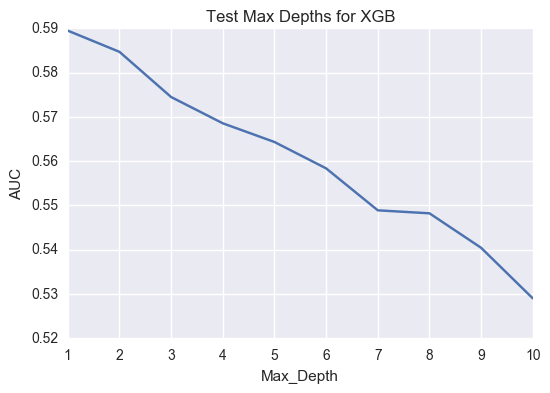

In [12]:
#plot results
cv_xgb = pd.Series(cv_xgb, index = max_depths)
cv_xgb.plot(title = "Test Max Depths for XGB")
plt.xlabel("Max_Depth")
plt.ylabel("AUC")
best_max_depth = cv_xgb.idxmax()

In [13]:
#cross validation for n_estimators
nestimators = np.linspace(91,110,dtype=int)
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=best_max_depth,n_estimators=nestimator)).mean()
          for nestimator in nestimators]


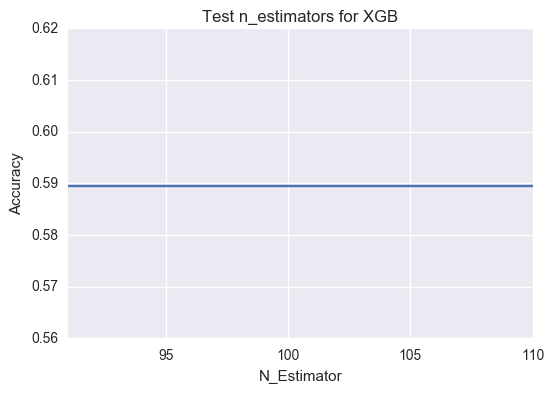

In [14]:
#plot results
cv_xgb = pd.Series(cv_xgb, index = nestimators)
cv_xgb.plot(title = "Test n_estimators for XGB")
plt.xlabel("N_Estimator")
plt.ylabel("Accuracy")
best_n_estimators = cv_xgb.idxmax()

In [15]:
#cross validation for colsample_bytree
colsample_bytree = np.linspace(.5,1)
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=best_max_depth,n_estimators=best_n_estimators,colsample_bytree=i)).mean()
          for i in colsample_bytree]


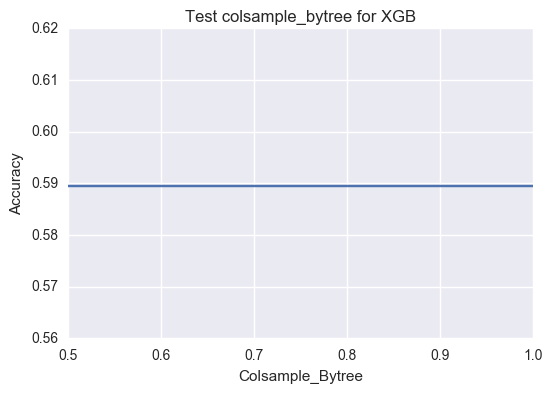

In [16]:
#plot results
cv_xgb = pd.Series(cv_xgb, index = colsample_bytree)
cv_xgb.plot(title = "Test colsample_bytree for XGB")
plt.xlabel("Colsample_Bytree")
plt.ylabel("Accuracy")
best_colsample_bytree = cv_xgb.idxmax()

XGB Train accuracy: 0.588868940754
XGB Test accuracy: 0.603231597846
crash_time : 0.250549
latitude : 0.173626
longitude : 0.169231
speed_limit : 0.0835165
intersection_related_Non Intersection : 0.0769231
crash_year : 0.0395604
road_base_type_Flex Base (Granular) : 0.0373626
day_of_week_Saturday : 0.0307692
day_of_week_Friday : 0.0307692
light_condition_Dark, Lighted : 0.0263736
manner_of_collision_One Motor Vehicle - Turning Right : 0.0241758
intersection_related_Driveway Access : 0.021978
light_condition_Dusk : 0.021978
light_condition_Dark, Unknown Lighting : 0.00659341
light_condition_Dawn : 0.0021978
manner_of_collision_One Motor Vehicle - Going Straight : 0.0021978
manner_of_collision_One Motor Vehicle - Other : 0.0021978


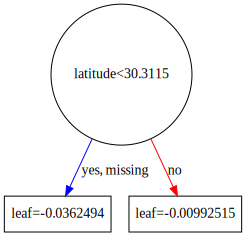

In [17]:
#train xgb model and check performance
model_xgb = XGBClassifier(max_depth=best_max_depth,colsample_bytree=best_colsample_bytree,n_estimators=best_n_estimators)
model_xgb.fit(x_train,y_train)
print("XGB Train accuracy:", model_xgb.score(x_train,y_train))
print("XGB Test accuracy:",model_xgb.score(x_test,y_test))

#print important features list and their overall importance in the xgb model
columns = []
feature_importances = []
for i in range(0,len(model_xgb.feature_importances_)):
    if model_xgb.feature_importances_[i]!=0:
        columns.append(x_train.columns[i])
        feature_importances.append(model_xgb.feature_importances_[i])
        
sorted_index = np.argsort(feature_importances)[::-1]
for i in sorted_index:
    print(columns[i],":",feature_importances[i])

to_graphviz(model_xgb)

0.250549 : crash_time
0.173626 : latitude
0.169231 : longitude
0.083516 : speed_limit
0.076923 : intersection_related_Non Intersection
0.039560 : crash_year
0.037363 : road_base_type_Flex Base (Granular)
0.030769 : day_of_week_Friday
0.030769 : day_of_week_Saturday
0.026374 : light_condition_Dark, Lighted
0.024176 : manner_of_collision_One Motor Vehicle - Turning Right
0.021978 : light_condition_Dusk
0.021978 : intersection_related_Driveway Access
0.006593 : light_condition_Dark, Unknown Lighting
0.002198 : manner_of_collision_One Motor Vehicle - Other
0.002198 : manner_of_collision_One Motor Vehicle - Going Straight
0.002198 : light_condition_Dawn


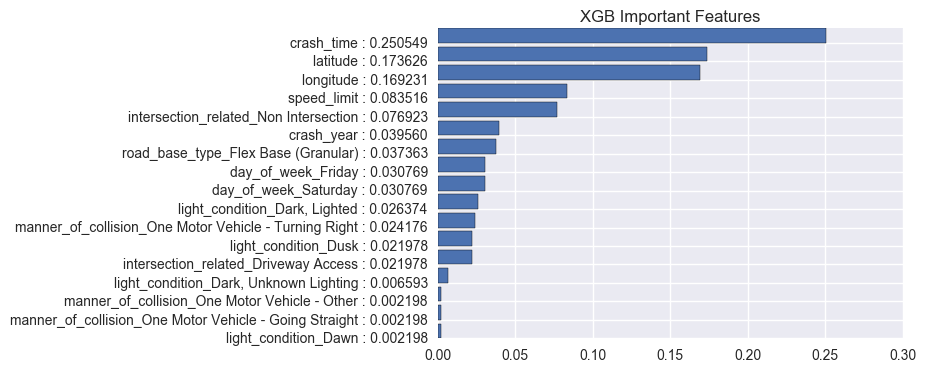

In [18]:
# print important features
xgb_imp_feats = helpers.print_model_feats_important(model_xgb, x_train.columns)
ax = helpers.get_ax_barh(xgb_imp_feats, title="XGB Important Features")
plt.show()

## Random Forest

In [24]:
#random forest
#train with limited number of features ,log2 works the best of the parameter options
np.random.seed(0)

#cross validate the max depth 
max_depths = np.linspace(1,10,10,dtype=int)
cv_max_depth = [accuracy_cv(RandomForestClassifier(max_features='log2',max_depth=max_depth)).mean()
          for max_depth in max_depths]

#print("cv_max_depth",cv_max_depth)
best_max_depth = cv_max_depth.index(max(cv_max_depth))+1

#cross validate the minimum number of leaves to minimize the difference in train/test error
min_leaves = np.linspace(1,50,50,dtype=int)
cv_randForest = [accuracy_cv(RandomForestClassifier(max_features='log2',
                                                               min_samples_leaf=min_leaf,
                                                              max_depth=best_max_depth)).mean()
          for min_leaf in min_leaves]

#retrain based on cross validation results
best_min_leaves = cv_randForest.index(max(cv_randForest))+1

randForest = RandomForestClassifier(max_features='log2',min_samples_leaf=best_min_leaves,max_depth=best_max_depth)
randForest.fit(x_train,y_train)

print("cv_randForest",max(cv_randForest))

#view performance of random forest
print("Random Forest Train accuracy:", randForest.score(x_train,y_train))
print("Random Forest Test accuracy:",randForest.score(x_test,y_test),"\n")
columns = []
feature_importances = []

#view importance features
for i in range(0,len(randForest.feature_importances_)):
    if randForest.feature_importances_[i]!=0:
        columns.append(x_train.columns[i])
        feature_importances.append(randForest.feature_importances_[i])
        
#sort importance features by importance
sorted_index = np.argsort(feature_importances)[::-1]
for i in sorted_index:
    print(columns[i],":",feature_importances[i])
    
randForest.get_params

cv_randForest 0.589477581143
Random Forest Train accuracy: 0.5894673848
Random Forest Test accuracy: 0.603231597846 

crash_time : 0.159975058216
longitude : 0.134593547854
latitude : 0.117350586355
speed_limit : 0.0827597880391
crash_year : 0.0717099280494
intersection_related_Intersection Related : 0.0340061020924
manner_of_collision_One Motor Vehicle - Going Straight : 0.0320774314338
road_base_type_Flex Base (Granular) : 0.031931260219
light_condition_Dark, Lighted : 0.0284777106523
day_of_week_Friday : 0.0269749158664
manner_of_collision_One Motor Vehicle - Turning Right : 0.0255763829774
day_of_week_Tuesday : 0.0241862346212
intersection_related_Driveway Access : 0.0214710949397
manner_of_collision_One Motor Vehicle - Turning Left : 0.0211203362882
intersection_related_Intersection : 0.0190885202753
intersection_related_Non Intersection : 0.0171815550178
day_of_week_Thursday : 0.0171657682115
light_condition_Daylight : 0.0170426988026
weather_condition_Cloudy : 0.0149330870456
da

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>

## KNN: K Nearest Neighbours

In [25]:
# KNN
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

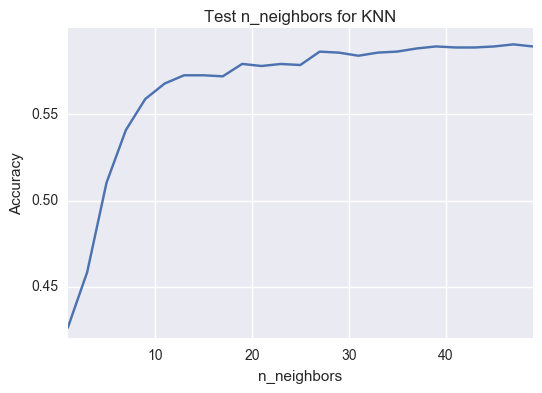

The optimal number of neighbors is 47
This has an accuracy of:  0.590676984138


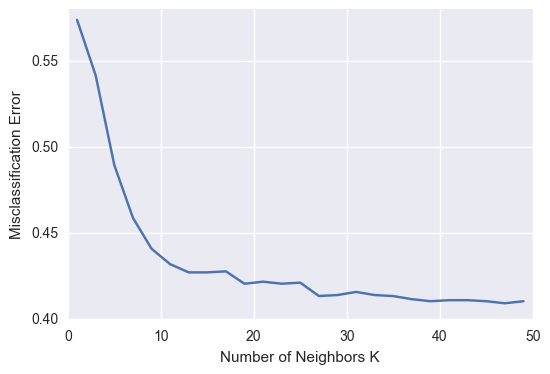

KNN Train accuracy: 0.588270496709
KNN Test accuracy: 0.603231597846


In [26]:
# plot results for KNN n_neighbors 
neighbors_list = list(filter(lambda x: x % 2 != 0, myList))
cv_knn = pd.Series(cv_scores, index=neighbors_list)
cv_knn.plot(title = "Test n_neighbors for KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.show()

# We can also show show this as misclassification error, and
# take the minimum.

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors_list[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)
print ("This has an accuracy of: ", cv_scores[MSE.index(min(MSE))])

# plot misclassification error vs k
plt.plot(neighbors_list, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

knn_model = KNeighborsClassifier(n_neighbors=optimal_k) # k = 29
knn_model.fit(x_train, y_train)

print("KNN Train accuracy:", knn_model.score(x_train,y_train))
print("KNN Test accuracy:", knn_model.score(x_test,y_test))

# Ensemble - Stacking The Models

In [27]:
#stack knn, decision tree, random forest, and model with xgb

#get predictions of all models for train and test data
x_train_knn_pred = knn_model.predict(x_train)
x_test_knn_pred = knn_model.predict(x_test)
x_train_rForest_pred = randForest.predict(x_train)
x_test_rForest_pred = randForest.predict(x_test)

#append data to train and test matrices
x_train['knn_pred'] = x_train_knn_pred
x_test['knn_pred'] = x_test_knn_pred
x_train['rForest_pred'] = x_train_rForest_pred
x_test['rForest_pred'] = x_test_rForest_pred

dummies_needed_list = [
    'knn_pred',
    'rForest_pred'
        ]

# encode x_train for dummies_needed_list
for feat in dummies_needed_list:
    x_train = pd.concat([x_train,pd.get_dummies(x_train[feat],prefix=feat)],axis=1)
    x_train = x_train.drop([feat],axis=1)
    
# encode x_test for dummies_needed_list
for feat in dummies_needed_list:
    x_test = pd.concat([x_test,pd.get_dummies(x_test[feat],prefix=feat)],axis=1)
    x_test = x_test.drop([feat],axis=1)

#add misisng features to ensure test and train are the same dimensions
missing_test_cols = list(set(x_train.columns)-set(x_test.columns))
for i in missing_test_cols:
    x_test[i] = 0
    
missing_train_cols = list(set(x_test.columns)-set(x_train.columns))
if len(missing_train_cols)>0:
    for i in missing_train_cols:
        x_train[i] = 0

#make sure features appear in the same order in train and test
cols = x_train.columns
x_test = x_test[cols]

In [28]:
#train xgb with new dataset

#find best input parameters
max_depths = np.linspace(1,5,5,dtype=int)
cv_stacked = [accuracy_cv(XGBClassifier(max_depth=max_depth)).mean()
              for max_depth in max_depths]
cv_stacked = pd.Series(cv_stacked,index=max_depths)
best_max_depth = cv_stacked.idxmax()

n_estimators = np.linspace(90,110,21,dtype=int)
cv_stacked = [accuracy_cv(XGBClassifier(max_depth=best_max_depth,n_estimators=n_estimator)).mean()
              for n_estimator in n_estimators]
cv_stacked = pd.Series(cv_stacked,index=n_estimators)
best_n_estimators = cv_stacked.idxmax()

colsamples = np.linspace(.6,1)
cv_stacked = [accuracy_cv(XGBClassifier(max_depth=best_max_depth,colsample_bytree=colsample)).mean()
              for colsample in colsamples]
cv_stacked = pd.Series(cv_stacked,index=colsamples)
best_colsamples = cv_stacked.idxmax()

In [29]:
#train model with new input parameters
model_xgb = XGBClassifier(max_depth=best_max_depth,colsample_bytree=best_colsamples,n_estimators=best_n_estimators)
model_xgb.fit(x_train,y_train)
print("XGB Train accuracy:", model_xgb.score(x_train,y_train))
print("XGB Test accuracy:",model_xgb.score(x_test,y_test),'\n')


XGB Train accuracy: 0.588868940754
XGB Test accuracy: 0.603231597846 



## Ensemble - Results

In [30]:
#print important features list and their overall importance in the xgb model
columns = []
feature_importances = []
for i in range(0,len(model_xgb.feature_importances_)):
    if model_xgb.feature_importances_[i]!=0:
        columns.append(x_train.columns[i])
        feature_importances.append(model_xgb.feature_importances_[i])
        
sorted_index = np.argsort(feature_importances)[::-1]
for i in sorted_index:
    print(columns[i],":",feature_importances[i])
    
#error with to_graphviz for this model. not sure what is causing it
#to_graphviz(model_xgb)

crash_time : 0.264444
longitude : 0.184444
latitude : 0.168889
intersection_related_Non Intersection : 0.0777778
speed_limit : 0.0755556
crash_year : 0.0377778
road_base_type_Flex Base (Granular) : 0.0355556
light_condition_Dark, Lighted : 0.0311111
day_of_week_Saturday : 0.0288889
day_of_week_Friday : 0.0288889
manner_of_collision_One Motor Vehicle - Turning Right : 0.0244444
light_condition_Dusk : 0.02
intersection_related_Driveway Access : 0.02
light_condition_Dark, Unknown Lighting : 0.00222222


Confusion matrix, without normalization


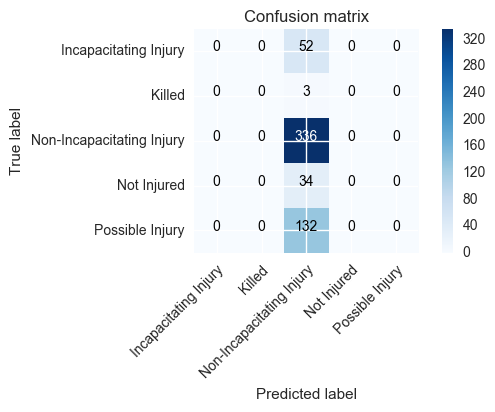

In [31]:
# interpret results
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,model_xgb.predict(x_test))
helpers.plot_confusion_matrix(cm,classes=model_xgb.classes_)

# Explainability using DecisionTree

Human-Readable Model
---

The complex model is good for making route predictions.

But what about getting an intuitive feel?

Decision Trees are good for creating explainable models.

In [32]:
###optimize with roc curve
#adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
#y_train = label_binarize(y_train,classes = ['Incapacitating Injury','Killed','Non-Incapacitating Injury','Not Injured','Possible Injury'])
#y_test = label_binarize(y_test,classes = ['Incapacitating Injury','Killed','Non-Incapacitating Injury','Not Injured','Possible Injury'])
n_classes = 5


#model_xgb = XGBClassifier(max_depth=5)
#model_xgb.fit(x_train,y_train)
classifier = OneVsRestClassifier(XGBClassifier(max_depth=3))
y_score = classifier.fit(x_train,y_train).predict_proba(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0,n_classes):
    fpr[i],tpr[i], _ = roc_curve(y_test[:,i],y_score[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])

fpr["micro"],tpr["micro"],_ = roc_curve(y_test.ravel(),y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])

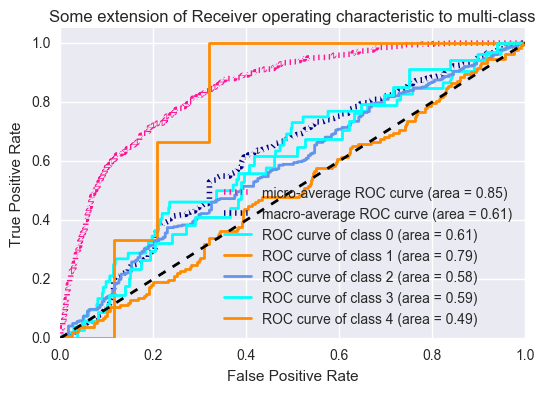

In [33]:
###from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
lw = 2

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [51]:
#cross validation function
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

lb = preprocessing.LabelBinarizer()
y_train = pd.DataFrame(lb.fit_transform(y_train))


def accuracy_cv(model):
    np.random.seed(0)
    model.fit(x_train,y_train)
    y_score = model.predict_proba(x_train)
#    accuracy = cross_val_score(model,x_train,y_train.as_matrix(),scoring=roc_auc_score(x_train,y_train,average='micro'),cv=5)
    accuracy = roc_auc_score(y_train,y_score,average='micro')
    return (accuracy)


max_depths = np.linspace(1,10,10,dtype=int)

#cross validation for max_depth parameter
cv_max_depth = [accuracy_cv(OneVsRestClassifier(XGBClassifier(max_depth=max_depth,colsample_bytree=best_colsample_bytree))).mean()
          for max_depth in max_depths]

In [46]:
#cross validation for n_estimators
nestimators = np.linspace(91,110,dtype=int)
cv_estimators = [accuracy_cv(OneVsRestClassifier(XGBClassifier(max_depth=best_max_depth,n_estimators=nestimator))).mean()
          for nestimator in nestimators]


In [47]:
#cross validation for colsample_bytree
colsample_bytree = np.linspace(.5,1)
cv_colsamples = [accuracy_cv(OneVsRestClassifier(XGBClassifier(colsample_bytree=i))).mean()
          for i in colsample_bytree]


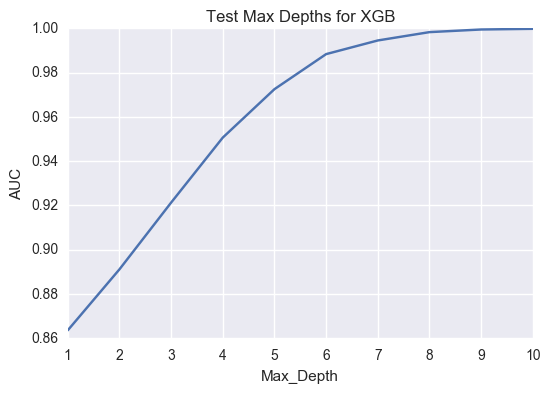

In [53]:
#plot results
cv_xgb = pd.Series(cv_max_depth, index = max_depths)
cv_xgb.plot(title = "Test Max Depths for XGB")
plt.xlabel("Max_Depth")
plt.ylabel("AUC")
best_max_depth = cv_xgb.idxmax()

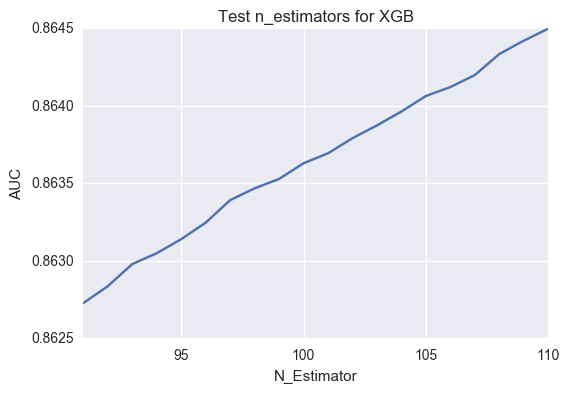

In [54]:
#plot results
cv_xgb = pd.Series(cv_estimators, index = nestimators)
cv_xgb.plot(title = "Test n_estimators for XGB")
plt.xlabel("N_Estimator")
plt.ylabel("AUC")
best_n_estimators = cv_xgb.idxmax()

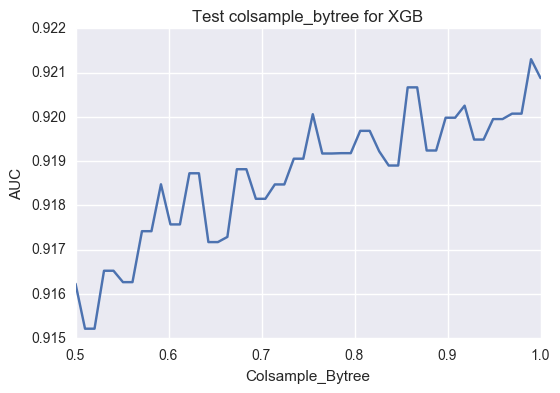

In [55]:
#plot results
cv_xgb = pd.Series(cv_colsamples, index = colsample_bytree)
cv_xgb.plot(title = "Test colsample_bytree for XGB")
plt.xlabel("Colsample_Bytree")
plt.ylabel("AUC")
best_colsample_bytree = cv_xgb.idxmax()